In [121]:
from matplotlib.image import imread 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import pandas as pd
import glob
import os
from PIL import Image, ImageEnhance
import skimage as ski

import warnings
warnings.filterwarnings("ignore")

In [122]:
# ----- Read filtered file -----
def read_reshape(nof):
    image = imread(nof)
    
    
    image.shape
    
    # image is represented in 3d matrix
    # first val is height
    # second val is width'
    # third val is # of color channels (RGBA)
    plt.title("Original image")
    plt.imshow(image)
    
    # -- Reshape image for processing ---
    X = image.reshape(-1,4)
    X.shape
    return X, image

In [123]:
# Create n clusters of colors
def segment(X, image): 
    kmeans = KMeans(n_clusters = num_clusters).fit(X)
    
    # -- Debugging
    # print(kmeans.cluster_centers_)
    # print(kmeans.labels_)
    
    segmented_image = kmeans.cluster_centers_[kmeans.labels_]
    # print(segemented_image)
    
    segmented_image = segmented_image.reshape(image.shape)
    segmented_image_pil = Image.fromarray((segmented_image * 255).astype(np.uint8))
    segmented_image_pil.save(f'./Images/Final/Classified/{date}.png')
    plt.title("Segmented Image")
    plt.imshow(segmented_image)
    return kmeans, segmented_image

In [124]:
def get_colors(kmeans, segmented):
    color = list(kmeans.cluster_centers_[3][:3])
    plt.figure(figsize=(6, 4))
    for i, color in enumerate(list(kmeans.cluster_centers_)):
        plt.subplot(1, num_clusters, i+1)
        plt.title(f"{i}")
        plt.imshow([[color[:3]]])
    
    
    hash = {}
    for index, color in enumerate(list(kmeans.cluster_centers_)):
        hash[index] = list(color)

    
    sorted_hash = sorted(hash.items(), key = lambda x: x[1][0], reverse = True)
    print("Sorted: ", sorted_hash)
    return sorted_hash


In [144]:
def silhouette(X, kmeans): 
    from sklearn.metrics import silhouette_score
    kmeans.inertia_
    # Calculate Silhouette score
    score = silhouette_score(X, kmeans.labels_)
    print("Silhouette Score", score)

In [125]:
# Determine whether there are unknown regions
def get_water(sorted_hash):
    r1 = sorted_hash[0][1][0]
    g1 = sorted_hash[0][1][1]
    b1 = sorted_hash[0][1][2]
    
    # r2 = sorted_hash[1][1][0]
    # g2 = sorted_hash[1][1][1]
    # b2 = sorted_hash[1][1][2]
    
    unknown = False
    # blue = False
    if (r1 < 0.03 and g1 < 0.03 and b1 < 0.03) or r1 > 0.5:
        print("Unkown region")
        unknown = True
    # elif r1 < 0.4 or b1 > 0.7:
    #     print("Blue Region marked")
    #     blue = True or r2 < 0.
        
    # if unknown and (r2 < 0.4 or b2 > 0.7):
    #     print("Blue Region marked")
    #     blue = True
    
    # res = 0
    # if unknown and blue:
    #     res = sorted_hash[2]
    # elif unknown or blue:
    #     res = sorted_hash[1]
    # else:
        # res = sorted_hash[0]
    
    if unknown:
        res = sorted_hash[1]
    else:
        res = sorted_hash[0]
    res = sorted_hash[0]
    
    adjusted = [int(num*255) for num in res[1]]
    print("Water RGB before adjusted: ", res[1])
    print("Adjusted RGB: ", adjusted)
    return adjusted

In [126]:
# - Split the image into respective sections -
def split(date):
    image = Image.open(f"./Images/Final/Classified/{date}.png")
    
    width, height = image.size
    
    # Define the coordinates for the vertical lines
    line1 = width / 4.4
    line2 = width / 2.13
    line3 = width / 1.48
    
    # Split the image into four regions
    region1 = image.crop((35, 0, line1, height))
    region2 = image.crop((line1, 0, line2, height))
    region3 = image.crop((line2, 0, line3, height))
    region4 = image.crop((line3, 0, width, height))
    
    
    # plt.subplot(1, 4, 1)
    # plt.imshow(region1)
    # plt.title("800-950")
    
    # plt.subplot(1,4,2)
    # plt.imshow(region2)
    # plt.title("950-1100")
    
    # plt.subplot(1,4,3)
    # plt.imshow(region3)
    # plt.title("1100-1250")
    
    # plt.subplot(1,4,4)
    # plt.imshow(region4)
    # plt.title("1250-1400")

    li = [region1, region2, region3, region4]
    for i in range(len(li)):
        li[1].save(f'./Images/Final/Bin{i+1}/{date}.png')

    return region1, region2, region3, region4

In [127]:
def get_individual(image, adjusted):
    image_array = np.array(image)
    
    # Reshape the image array to a 1D array of pixels
    pixels = image_array.reshape(-1, image_array.shape[-1])
    
    # Find the unique pixels
    unique_pixels, counts = np.unique(pixels, axis = 0, return_counts = True)
    
    data = {}
    marked = False
    for i, (pixel, num) in enumerate(zip(unique_pixels, counts)):
        r, g, b, a = pixel
        if int(r) == 0 and int(g) == 0 and int(b) == 0:
            print("Unknown spot detected during calculation...removing")
            marked = True
            continue
        else:
            data[tuple(pixel)] = num

    
    
    # adjusted corresponds to the rgb after converting it to 0-255
    if tuple(adjusted) in data:
        water = data[tuple(adjusted)]
    else:
        water = 0 
    total_pixels = sum(data.values())

    if total_pixels != 0: 
        ratio = round(water / total_pixels, 6)
        ratio *= 100
    else:
        ratio = 0

    return ratio

In [134]:
def contrast(nof, year, date): 
    
    image = Image.open(nof)
    
    enhancer = ImageEnhance.Contrast(image)
    factor = 1 #prev 0.9
    newimg = enhancer.enhance(factor)
    
    brightness_factor = 0.7 # prev 0.7
    enhancer = ImageEnhance.Brightness(newimg)
    final_image = enhancer.enhance(brightness_factor)
    
    
    saturation_factor = 1 #prev 3.5
    enhancer = ImageEnhance.Color(final_image)
    img = enhancer.enhance(saturation_factor)
    img.save(f"./Images/Final/{year}/Adjusted/{date}.png")

        

In [143]:
def get_data(date, year, name_of_file, num_clusters):
    out, original = read_reshape(name_of_file)
    kmeans, seg = segment(out, original)
    ##silhouette(out, kmeans)
    sorted_colors = get_colors(kmeans, seg)
    water = get_water(sorted_colors)
    if water == False:
        print("****FAILED****")
        return 
    reg1, reg2, reg3, reg4 = split(date)
    return water, reg1, reg2, reg3, reg4, seg

DATE: 20200612


KeyboardInterrupt: 

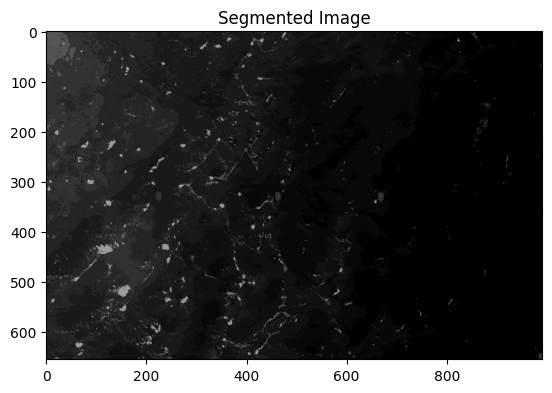

In [146]:
data_bin1 = {}
data_bin2 = {}
data_bin3 = {}
data_bin4 = {}
data_no_bin = {}
year = "2020"
num_clusters = 8

water_color = {}

files = glob.glob(f"./Images/Final/{year}/*.png")
dates = [date[-12:-4] for date in files]
#dates = ["20200821"]
for date in dates: 
    print("DATE:", date)
    name_of_file = f"./Images/Final/{year}/{date}.png"
    contrast(name_of_file, year, date)
    name_of_file = f"./Images/Final/{year}/Adjusted/{date}.png"
    water, reg1, reg2, reg3, reg4, seg = get_data(date, year, name_of_file, num_clusters)
    water_color[date] = water[:3]
    li = [reg1, reg2, reg3, reg4]
    hash_li = [data_bin1, data_bin2, data_bin3, data_bin4]
    for i in range(len(li)):
        ratio = get_individual(li[i], water)
        print(f"Bin {i+1}: {ratio} on {date}")
        hash_li[i][date] = ratio
    entire_image = Image.open(f"./Images/Final/Classified/{date}.png")
    ratio_total = get_individual(entire_image, water)
    print(f"Total: {ratio_total} on {date}")
    data_no_bin[date] = ratio_total
    print("\n")



In [137]:
print(data_bin1)
print(data_bin2)
print(data_bin3)
print(data_bin4)
print(data_no_bin)


{'20200612': 1.5082, '20200617': 2.0031, '20200627': 1.1108, '20200705': 0.6696, '20200717': 0.47800000000000004, '20200722': 0.28300000000000003, '20200730': 0.15460000000000002, '20200811': 0.0424, '20200821': 0.026600000000000002}
{'20200612': 0.8174000000000001, '20200617': 1.7771, '20200627': 3.0284999999999997, '20200705': 0.4632, '20200717': 0.6597000000000001, '20200722': 0.5087, '20200730': 0.40590000000000004, '20200811': 0.33549999999999996, '20200821': 0.2916}
{'20200612': 0.0886, '20200617': 0.13979999999999998, '20200627': 1.1821, '20200705': 1.6362, '20200717': 1.2162, '20200722': 1.3105, '20200730': 0.6133000000000001, '20200811': 0.416, '20200821': 0.2029}
{'20200612': 0.0052, '20200617': 0.0072, '20200627': 0.32820000000000005, '20200705': 1.0832, '20200717': 3.1676999999999995, '20200722': 2.5737, '20200730': 1.5230000000000001, '20200811': 1.0954, '20200821': 0.1794}
{'20200612': 0.5307000000000001, '20200617': 0.8710000000000001, '20200627': 1.3004, '20200705': 0.9

In [138]:
data = {1: data_bin1, 2: data_bin2, 3: data_bin3, 4: data_bin4}

In [139]:
def create_table():
    df = pd.DataFrame(columns = ["Year", "X", "Y", "Type", "Bands", "Bin"])
    dir = "./main.csv"
    if os.path.exists(dir): 
        return
    else:
        print("Creating table...")
        df.to_csv(directory, index = False)

In [140]:
def save_table(obj, year, method, bands, bin):
    create_table()
    new_obj = {"X": obj.keys(),
               "Y": obj.values(),
               "Year": year,
               "Type": method, 
               "Bands": bands,
               "Bin": bin
              }
    df = pd.DataFrame(new_obj)
    temp = df.to_csv("./temp.csv", index = False)
    print("Appending")
    existing_df = pd.read_csv("./main.csv")
    new_df = pd.read_csv("./temp.csv")

    existing_df = pd.concat([existing_df, new_df], ignore_index = True)
    #existing_df = existing_df.drop_duplicates()
    existing_df = existing_df.sort_values(by="X")

    existing_df = existing_df.drop_duplicates(subset=["Year", "X", "Type", "Bands", "Bin"], keep="last")
    existing_df = existing_df.sort_values(by=["Bin", "Year"])
    existing_df.to_csv("./main.csv", index = False)

In [141]:
for i in range(len(data)):
    save_table(data[i+1], year, "Kmeans", "9", i+1)

Appending
Appending
Appending
Appending


In [142]:
save_table(data_no_bin, year, "Kmeans", "9", -1)

Appending


In [95]:
print(water_color)

{'20220615': [253, 214, 82], '20220625': [250, 197, 65], '20220708': [254, 9, 235], '20220710': [219, 150, 30], '20220720': [223, 162, 23], '20220729': [67, 66, 67], '20220813': [81, 81, 81], '20220828': [243, 15, 28]}


In [99]:
# [253, 214, 82], [250, 197, 65], [219, 150, 30], [223, 162, 23]
lower = [210, 140, 20]
upper = [252, 220, 90]
newLower = []
newUpper = []
for (i, j) in zip(lower, upper): 
    newLower.append(round(i/255, 2))
    newUpper.append(round(j/255, 2))
print(newLower)
print(newUpper)

[0.82, 0.55, 0.08]
[0.99, 0.86, 0.35]


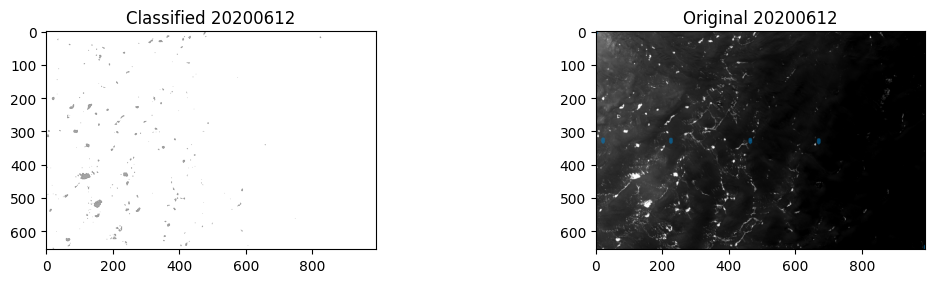

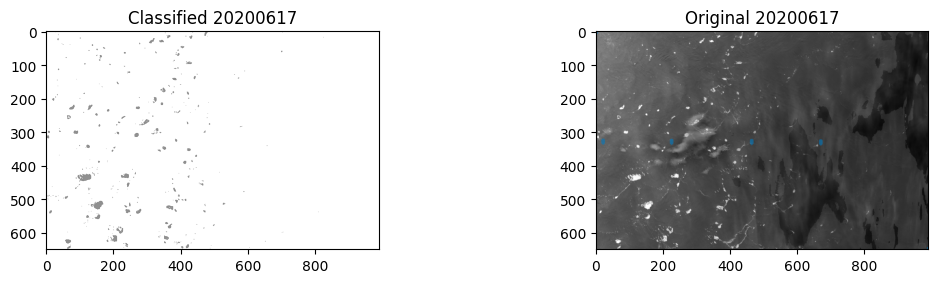

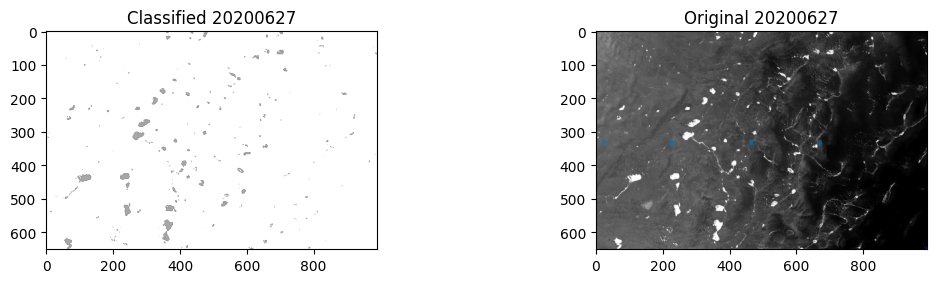

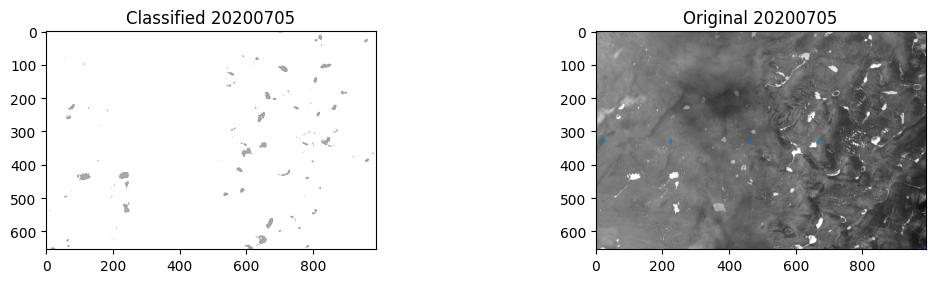

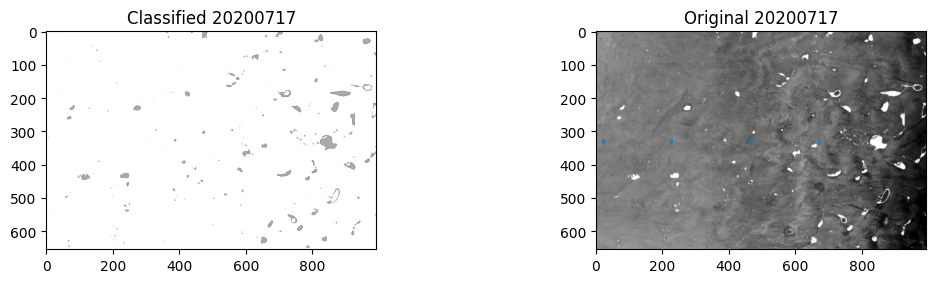

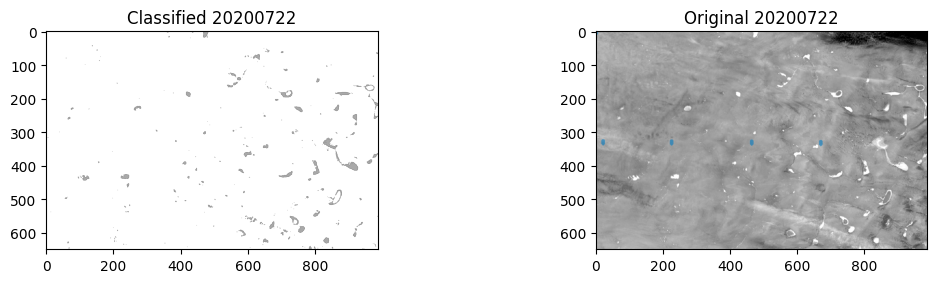

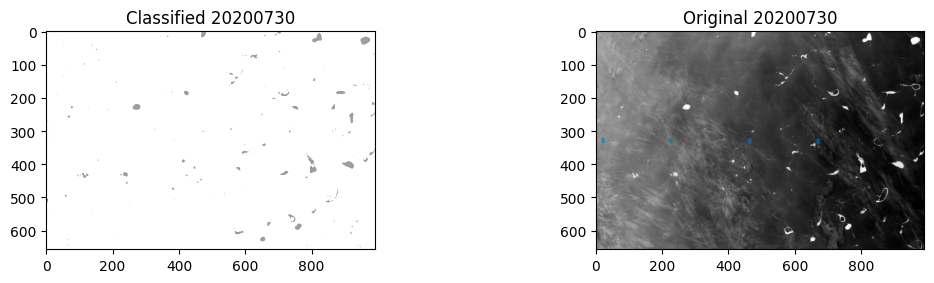

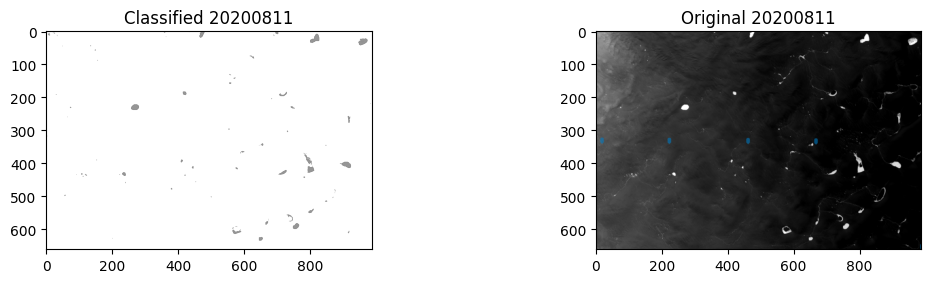

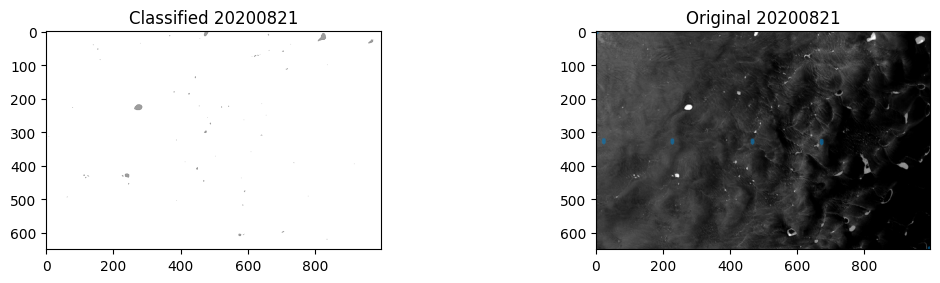

In [136]:
def test(year, date, obj, num): 
    image = Image.open(f"./Images/Final/Classified/{date}.png")
    original = Image.open(f"./Images/Final/{year}/{date}.png")
    
    image_array = np.array(image)
    
    
    image_rgb = image_array[:, :, :3]
    
    
    target_color = np.array(obj[date])
    
    
    mask = np.all(image_rgb == target_color, axis=-1)
    
    
    filtered_image_array = np.zeros_like(image_array)
    filtered_image_array[mask] = image_array[mask]
    
    
    filtered_image = Image.fromarray(filtered_image_array)

    plt.figure(figsize=(13, 30))
    
    plt.subplot(9, 2,num)
    plt.title(f"Classified {date}")
    plt.imshow(filtered_image)
    
    plt.subplot(9,2,num+1)
    plt.title(f"Original {date}")
    plt.imshow(original)


for i, date in enumerate(dates):
    test(year, date, water_color, 2*i+1)

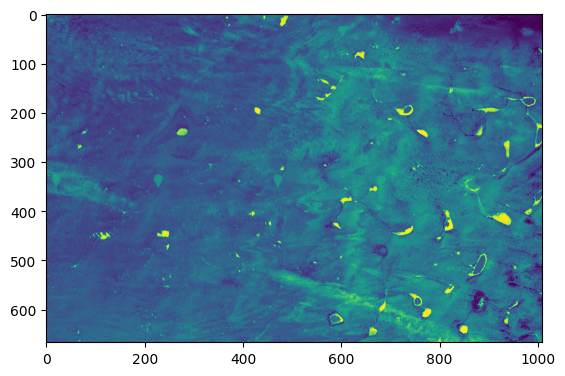

In [101]:
from PIL import Image, ImageOps   

image = Image.open("./Images/Final/2020/20200722.png")
if image.mode != "L":
    image = image.convert("L")

# Invert the image
inverted_image = Image.eval(image, lambda x: 255 - x)

# Show the inverted image
plt.imshow(inverted_image)

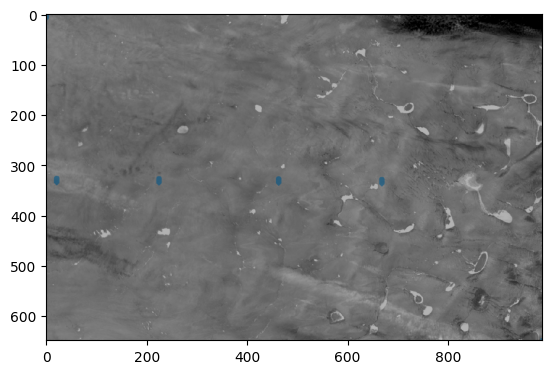

In [120]:

image = Image.open("./Images/Final/2020/20200722.png")

enhancer = ImageEnhance.Contrast(image)
factor = 1
newimg = enhancer.enhance(factor)

brightness_factor = 0.7
enhancer = ImageEnhance.Brightness(newimg)
final_image = enhancer.enhance(brightness_factor)


saturation_factor = 1
enhancer = ImageEnhance.Color(final_image)
img = enhancer.enhance(saturation_factor)

plt.imshow(img)

True

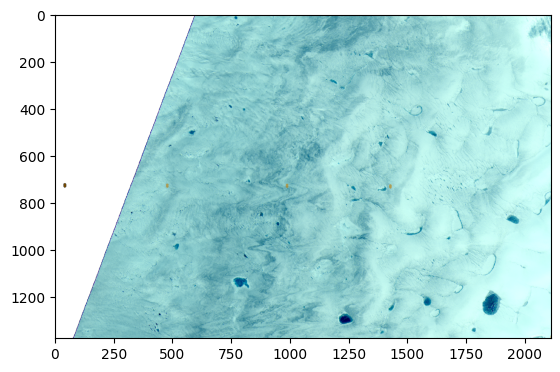

In [259]:
image = Image.open("./Images/Final/2022/20220625.png")

brightness_factor = 6
enhancer = ImageEnhance.Brightness(image)
final_image = enhancer.enhance(brightness_factor)

final_image.save(f"./Images/Final/Temp/20200625.png")

src = cv2.imread("./Images/Final/2022/20220828.png", 1) 
  
# Convert image to image gray 
tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY) 
  
# Applying thresholding technique 
_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY) 
  
# Using cv2.split() to split channels  
# of coloured image 
b, g, r = cv2.split(src) 
  
# Making list of Red, Green, Blue 
# Channels and alpha 
rgba = [b, g, r, alpha] 
  
# Using cv2.merge() to merge rgba 
# into a coloured/multi-channeled image 
dst = cv2.merge(rgba, 4) 
  
# Writing and saving to a new image 
plt.imshow(dst)

cv2.imwrite("./Images/template.png", dst)